In [1]:
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calculate_distance(residue1, residue2):
    """ アミノ酸残基間の距離を計算する """
    diff_vector = residue1['CA'].coord - residue2['CA'].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

In [9]:
def create_contact_map(pdb_id):
    """ コンタクトマップを作成する """
    parser = PDBParser()
    structure = parser.get_structure(pdb_id, "pdb/{}.pdb".format(pdb_id))
    model = structure[0]

    residues = [residue for residue in model.get_residues() if residue.has_id('CA')]
    n_residues = len(residues)
    contact_map = np.zeros((n_residues, n_residues))

    for i, residue1 in enumerate(residues):
        for j, residue2 in enumerate(residues):
            distance = calculate_distance(residue1, residue2)
            contact_map[i, j] = distance

    return contact_map

In [10]:
ls pdb

A0A024RBG1.pdb  P15976.pdb      Q10713.pdb      Q8IV31.pdb      Q9BXT6.pdb
A0A087WT00.pdb  P16035.pdb      Q12765.pdb      Q8IV38.pdb      Q9BXU8.pdb
A0A087WWM6.pdb  P16066.pdb      Q12768.pdb      Q8IV42.pdb      Q9BXU9.pdb
A0A087WY85.pdb  P16070.pdb      Q12769.pdb      Q8IV50.pdb      Q9BXV9.pdb
A0A087WZG4.pdb  P16083.pdb      Q12770.pdb      Q8IV56.pdb      Q9BXW4.pdb
A0A0A0MQY9.pdb  P16109.pdb      Q12772.pdb      Q8IV77.pdb      Q9BXW6.pdb
A0A0A0MS75.pdb  P16112.pdb      Q12778.pdb      Q8IVB4.pdb      Q9BXX0.pdb
A0A0A0MSU8.pdb  P16118.pdb      Q12789.pdb      Q8IVE3.pdb      Q9BXX2.pdb
A0A0A6YYB9.pdb  P16152.pdb      Q12796.pdb      Q8IVF6.pdb      Q9BXX3.pdb
A0A0A6YYJ0.pdb  P16157.pdb      Q12797.pdb      Q8IVH4.pdb      Q9BXY0.pdb
A0A0A6YYJ9.pdb  P16219.pdb      Q12798.pdb      Q8IVH8.pdb      Q9BXY4.pdb
A0A0A6YYL0.pdb  P16220.pdb      Q12809.pdb      Q8IVL5.pdb      Q9BXY5.pdb
A0A0A6YYL1.pdb  P16233.pdb      Q12815.pdb      Q8IVN3.pdb      Q9BXY8.pdb
A0A0B4J1V8.pdb  P16234.pd

In [11]:
pdb_id = 'P15976'
contact_map = create_contact_map(pdb_id)

In [24]:
contact_map

array([[ 0.        ,  3.47470021,  6.83631754, ..., 93.05179596,
        96.03288269, 98.88800812],
       [ 3.47470021,  0.        ,  3.78138518, ..., 91.62859344,
        94.58428955, 97.35945129],
       [ 6.83631754,  3.78138518,  0.        , ..., 88.4138031 ,
        91.33454132, 94.06668091],
       ...,
       [93.05179596, 91.62859344, 88.4138031 , ...,  0.        ,
         3.80397773,  6.82840824],
       [96.03288269, 94.58428955, 91.33454132, ...,  3.80397773,
         0.        ,  3.7811563 ],
       [98.88800812, 97.35945129, 94.06668091, ...,  6.82840824,
         3.7811563 ,  0.        ]])

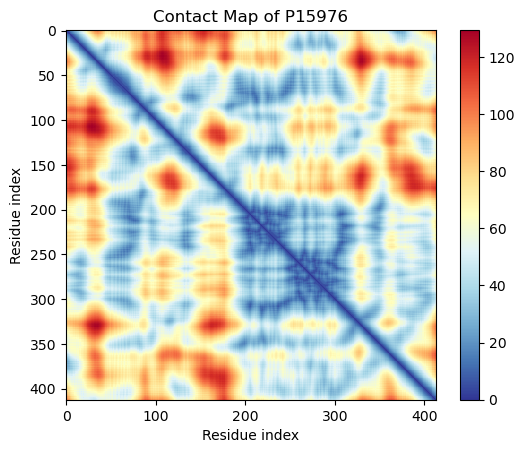

In [14]:
plt.imshow(contact_map, cmap='RdYlBu_r', interpolation='nearest')
plt.colorbar()
plt.title(f"Contact Map of {pdb_id}")
plt.xlabel("Residue index")
plt.ylabel("Residue index")
plt.show()

In [15]:
import torch
import numpy as np 
from torch_geometric.data import Data, Dataset, Batch
import csv
import glob
import numpy as np
from joblib import Parallel, delayed, cpu_count
import sys
from datetime import datetime
from tqdm import tqdm
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn import metrics
from Bio import SeqIO
from Bio.PDB.PDBParser import PDBParser
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_fscore_support

In [16]:
RES2ID = {
    'A':0,
    'R':1,
    'N':2,
    'D':3,
    'C':4,
    'Q':5,
    'E':6,
    'G':7,
    'H':8,
    'I':9,
    'L':10,
    'K':11,
    'M':12,
    'F':13,
    'P':14,
    'S':15,
    'T':16,
    'W':17,
    'Y':18,
    'V':19,
    '-':20
}

In [17]:
def aa2idx(seq):
    # convert letters into numbers
    abc = np.array(list("ARNDCQEGHILKMFPSTWYVX"), dtype='|S1').view(np.uint8)
    idx = np.array(list(seq), dtype='|S1').view(np.uint8)
    for i in range(abc.shape[0]):
        idx[idx == abc[i]] = i

    # treat all unknown characters as gaps
    idx[idx > 20] = 20
    return idx

In [18]:
def protein_graph(sequence, edge_index, esm_embed):
    seq_code = aa2idx(sequence)
    seq_code = torch.IntTensor(seq_code)
    # add edge to pairs whose distances are more possible under 8.25
    #row, col = edge_index
    edge_index = torch.LongTensor(edge_index)
    # if AF_embed == None:
    #     data = Data(x=seq_code, edge_index=edge_index)
    # else:
    data = Data(x=torch.from_numpy(esm_embed), edge_index=edge_index, native_x=seq_code)
    return data

In [19]:
def pmap_multi(pickleable_fn, data, n_jobs=None, verbose=1, desc=None, **kwargs):

    if n_jobs is None:
        n_jobs = cpu_count() - 1

    results = Parallel(n_jobs=n_jobs, verbose=verbose, timeout=None)(
        delayed(pickleable_fn)(*d, **kwargs) for i, d in tqdm(enumerate(data),desc=desc)
    )

    return results

In [20]:
def pmap_single(pickleable_fn, data, n_jobs=None, verbose=1, desc=None, **kwargs):

    if n_jobs is None:
        n_jobs = cpu_count() - 1

    results = Parallel(n_jobs=n_jobs, verbose=verbose, timeout=None)(
    delayed(pickleable_fn)(d, **kwargs) for i, d in tqdm(enumerate(data),desc=desc)
    )

    return results

In [21]:
def load_predicted_PDB(pdbfile):
    # Generate (diagonalized) C_alpha distance matrix from a pdbfile
    parser = PDBParser()
    structure = parser.get_structure(pdbfile.split('/')[-1].split('.')[0], pdbfile)
    residues = [r for r in structure.get_residues()]

    # sequence from atom lines
    records = SeqIO.parse(pdbfile, 'pdb-atom')
    seqs = [str(r.seq) for r in records]

    distances = np.empty((len(residues), len(residues)))
    for x in range(len(residues)):
        for y in range(len(residues)):
            one = residues[x]["CA"].get_coord()
            two = residues[y]["CA"].get_coord()
            distances[x, y] = np.linalg.norm(one-two)

    return distances, seqs[0]

In [23]:
load_predicted_PDB("pdb/{}.pdb".format(pdb_id))

/Users/yoshitakainoue/.pyenv/versions/miniforge3-4.10.1-5/envs/py310/lib/python3.10/site-packages/Bio/SeqIO/PdbIO.py:322: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  warnings.warn(


(array([[ 0.        ,  3.47470021,  6.83631754, ..., 93.05179596,
         96.03288269, 98.88800812],
        [ 3.47470021,  0.        ,  3.78138518, ..., 91.62859344,
         94.58428955, 97.35945129],
        [ 6.83631754,  3.78138518,  0.        , ..., 88.4138031 ,
         91.33454132, 94.06668091],
        ...,
        [93.05179596, 91.62859344, 88.4138031 , ...,  0.        ,
          3.80397773,  6.82840824],
        [96.03288269, 94.58428955, 91.33454132, ...,  3.80397773,
          0.        ,  3.7811563 ],
        [98.88800812, 97.35945129, 94.06668091, ...,  6.82840824,
          3.7811563 ,  0.        ]]),
 'MEFPGLGSLGTSEPLPQFVDPALVSSTPESGVFFPSGPEGLDAAASSTAPSTATAAAAALAYYRDAEAYRHSPVFQVYPLLNCMEGIPGGSPYAGWAYGKTGLYPASTVCPTREDSPPQAVEDLDGKGSTSFLETLKTERLSPDLLTLGPALPSSLPVPNSAYGGPDFSSTFFSPTGSPLNSAAYSSPKLRGTLPLPPCEARECVNCGATATPLWRRDRTGHYLCNACGLYHKMNGQNRPLIRPKKRLIVSKRAGTQCTNCQTTTTTLWRRNASGDPVCNACGLYYKLHQVNRPLTMRKDGIQTRNRKASGKGKKKRGSSLGGTGAAEGPAGGFMVVAGGSGSGNCGEVASGLTLGPPGTAHLYQGLGPVV

In [27]:
from Bio.PDB.PDBParser import PDBParser
import numpy as np
import glob
import sys, os
import pickle as pkl
import argparse 
import torch
from torch_geometric.data import Data, Batch
from utils import protein_graph
from network import CL_protNET
from utils import load_GO_annot
import esm

In [28]:
restype_1to3 = {
    'A': 'ALA',
    'R': 'ARG',
    'N': 'ASN',
    'D': 'ASP',
    'C': 'CYS',
    'Q': 'GLN',
    'E': 'GLU',
    'G': 'GLY',
    'H': 'HIS',
    'I': 'ILE',
    'L': 'LEU',
    'K': 'LYS',
    'M': 'MET',
    'F': 'PHE',
    'P': 'PRO',
    'S': 'SER',
    'T': 'THR',
    'W': 'TRP',
    'Y': 'TYR',
    'V': 'VAL',
}

In [42]:
restype_3to1 = {v: k for k, v in restype_1to3.items()}

pdb = "pdb/{}.pdb".format(pdb_id)
parser = PDBParser()

struct = parser.get_structure("x", pdb)
model = struct[0]
chain_id = list(model.child_dict.keys())[0]
chain = model[chain_id]
Ca_array = []
sequence = ''
seq_idx_list = list(chain.child_dict.keys())
seq_len = seq_idx_list[-1][1] - seq_idx_list[0][1] + 1

for idx in range(seq_idx_list[0][1], seq_idx_list[-1][1]+1):
    try:
        Ca_array.append(chain[(' ', idx, ' ')]['CA'].get_coord())
    except:
        Ca_array.append([np.nan, np.nan, np.nan])
    try:
        sequence += restype_3to1[chain[(' ', idx, ' ')].get_resname()]
    except:
        sequence += 'X'

#print(sequence)
Ca_array = np.array(Ca_array)
    
resi_num = Ca_array.shape[0]
G = np.dot(Ca_array, Ca_array.T)
H = np.tile(np.diag(G), (resi_num,1))
dismap = (H + H.T - 2*G)**0.5

In [49]:
device = 'mps'

esm_model, alphabet = esm.pretrained.load_model_and_alphabet_local(
    '/Users/yoshitakainoue/Downloads/esm1b_t33_650M_UR50S.pt'
)

KeyboardInterrupt: 

In [38]:

batch_converter = alphabet.get_batch_converter()
esm_model = esm_model.to(device)

esm_model.eval()

batch_labels, batch_strs, batch_tokens = batch_converter([('tmp', sequence)])
batch_tokens = batch_tokens.to(device)
with torch.no_grad():
    results = esm_model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33][0].cpu().numpy().astype(np.float16)
    esm_embed = token_representations[1:len(sequence)+1]

row, col = np.where(dismap <= 10)
edge = [row, col]
graph = protein_graph(sequence, edge, esm_embed)

GraphACL-BIO.png* model_bpCLaf.pt   model_ccCLaf.pt   model_mfCLaf.pt
model_bpCL.pt     model_ccCL.pt     model_mfCL.pt
